# Read in the data

In [36]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [37]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


# Add DBN columns

In [38]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [39]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [40]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [41]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [42]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [43]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [45]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.412667
Total Exams Taken                       0.388975
Number of Exams with scores 3 4 or 5    0.382931
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent                            -0.398750
sped_num            

# Survey data plot

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


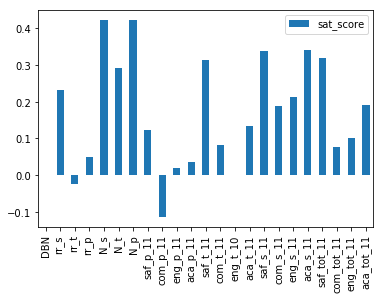

In [84]:
import matplotlib.pyplot as plt
survey_cor = correlations.loc[survey_fields]
survey_cor = pd.DataFrame(survey_cor)
survey_cor.dropna()
survey_cor.plot.bar()
plt.xticks(rotation = 90)
plt.show()

N_S (number of students responded),N_p(number of parents responded) are the two most positive related factors to the SAT score. There is a clear tendency for students getting high SAT scores to disclose their scores. This shows bias in the data set.<br>
<br>
Saf_t_11(Safety and Respect score based on teacher responses) and saf_s_11(Safety and Respect score based on student responses) are another two high positive correlation factors to sat score. Higher safety preceived in school, better the score.


# Safety and SAT score

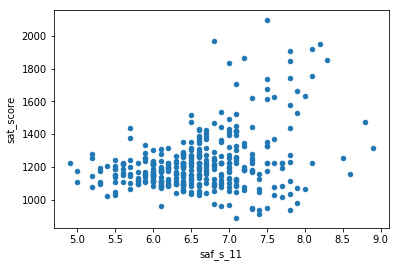

In [47]:
combined.plot.scatter(x='saf_s_11',y='sat_score')
plt.show()

From the scatter plot, we can see a slight positive trend between the safety and SAT score. For school with less 6.5 safety score, it is impossible for them to reach over 1500 in SAT.

D:\Anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
D:\Anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


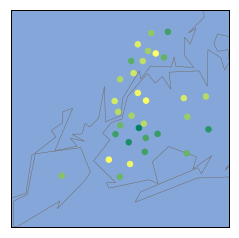

In [49]:
from mpl_toolkits.basemap import Basemap
district = combined.groupby('school_dist').agg(np.mean)
district.reset_index(inplace = True)
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

latitude = district['lat'].tolist()
longitude = district['lon'].tolist()

m.scatter(longitude,latitude,s=30,zorder =2,latlon = True,c=district['saf_s_11'],cmap= 'summer')
plt.show()

Brooklyn is least safe in new york. Average sat score may be lower

# Racial and SAT

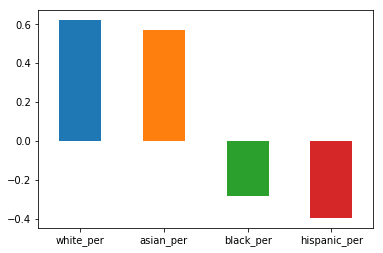

In [82]:
ax = correlations.loc[['white_per','asian_per','black_per','hispanic_per']].plot.bar()
ax.set_xticklabels(['white_per','asian_per','black_per','hispanic_per'],rotation = 0)
plt.show()

There is a strong evidence that higher white and asian people in schools will correlate to higher SAT scores. <br>


In [60]:
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,107.419512,131.425,...,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,40.713764,-73.985260,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000,...,"200 Monroe Street\nNew York, NY 10002\n(40.712...",3.0,1.0,202.0,1003214.0,1.002590e+09,Lower East Side ...,40.712332,-73.984797,01
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000,...,"420 East 12 Street\nNew York, NY 10009\n(40.72...",3.0,2.0,34.0,1005974.0,1.004390e+09,East Village ...,40.729783,-73.983041,01
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,107.419512,131.425,...,"145 Stanton Street\nNew York, NY 10002\n(40.72...",3.0,1.0,3001.0,1004323.0,1.003540e+09,Chinatown ...,40.720569,-73.985673,01
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000,...,"111 Columbia Street\nNew York, NY 10002\n(40.7...",3.0,2.0,2201.0,1004070.0,1.003350e+09,Lower East Side ...,40.718725,-73.979426,01


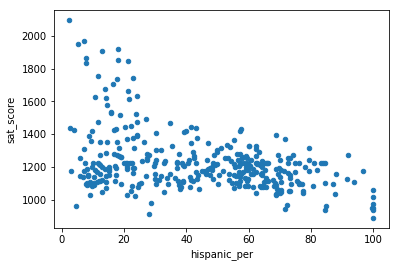

In [67]:
combined.plot.scatter(x='hispanic_per',y='sat_score')
plt.show()

Clearly, there is a negative correlation between hispanic percentage and sat score. With over 30% of hispanic, schools are imppossible to have a student get mark higher than 1500 in SAT. This is a strange result. Let's figure out why.

In [62]:
combined[combined['hispanic_per'] > 95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Most of them serve english-as-a-second-language immigrants. Among the immigrants, the proportion of hispanic is high. Given the above reason, there is reason for higher hispanic proportion relating to lower SAT score. 

In [65]:
combined[combined['sat_score'] > 1800]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
37                                STUYVESANT HIGH SCHOOL
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

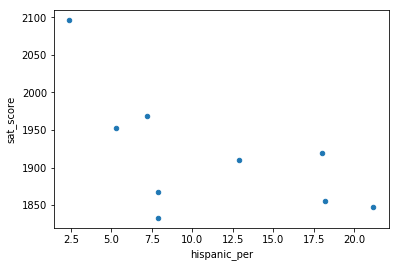

In [66]:
combined[combined['sat_score'] > 1800].plot.scatter(x='hispanic_per',y='sat_score')
plt.show()

Schools are specialized in the science or tech fields with huge funds. According to the scatter plot, there seems the hispanics proportion is reasonable, given that the hispanic population accounts for 16.7% of the US population. This reflects no discrimination on hispanics.

# Gender and SAT score

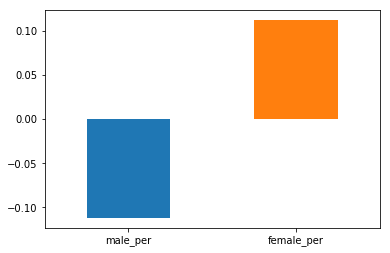

In [80]:
ax = correlations.loc[['male_per','female_per']].plot.bar()
ax.set_xticklabels(['male_per','female_per'],rotation = 0)
plt.show()

Based on the bar chart, school with higher percentage of male will have worse performance in SAT. It raises a concern that whether women can get higher score in SAT by nature. However, the relation is weak.

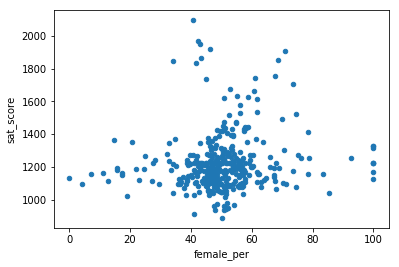

In [89]:
combined.plot.scatter("female_per", "sat_score")
plt.show()

In [87]:
combined[combined['female_per'] > 60][combined['sat_score'] > 1500]['SCHOOL NAME']

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


5                         BARD HIGH SCHOOL EARLY COLLEGE
22              PROFESSIONAL PERFORMING ARTS HIGH SCHOOL
26                         ELEANOR ROOSEVELT HIGH SCHOOL
27                                MILLENNIUM HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
287                    BARD HIGH SCHOOL EARLY COLLEGE II
302                          TOWNSEND HARRIS HIGH SCHOOL
325    QUEENS GATEWAY TO HEALTH SCIENCES SECONDARY SC...
Name: SCHOOL NAME, dtype: object

From the scatter plot, there is no true relation between gender and sat performance. Even after investigating the schools with higher female proportion, there is no evidence to support there is any bias based on gender

# Advanced Placement (AP) exams and SAT score

In [94]:
# percetage of taking ap test
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined['ap_per'].head()

0    0.254549
1    0.098985
2    0.031773
3    0.292696
4    0.158091
Name: ap_per, dtype: float64

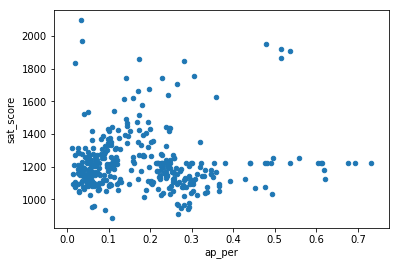

In [95]:
combined.plot.scatter(x='ap_per',y='sat_score')
plt.show()

From the plot, there is no relation between ap test percentage and SAT score.